### Notebook for annotating the 6mpi cardiac MoMacs using `celltypist`

#### Environment: Celltypist

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240325
- **Last modified**: 240325

### Load required modules

In [1]:
import scanpy as sc
import anndata 
import celltypist
from celltypist import models
from scipy.sparse import csr_matrix

import logging
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=100)
%matplotlib inline

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                 10.2.0
asttokens           NA
brotli              1.1.0
celltypist          1.6.2
certifi             2024.02.02
charset_normalizer  3.3.2
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
idna                3.6
igraph              0.11.4
ipykernel           6.29.3
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.3
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging           24.0
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.0
prompt_toolk

In [3]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

##### Load in dataset that was clustered with `leiden`

In [4]:
input = '/home/acirnu/data/ACM_cardiac_leuco/scANVI/ACM_myeloids_leiden_clustering_on_Pkp2_Ctr_noninf_ac240325.raw.h5ad'
adata = sc.read_h5ad(input)
adata

AnnData object with n_obs × n_vars = 3760 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'n_genes', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropou

In [5]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 3760 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'n_genes', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropou

In [6]:
X_is_raw(adata)

True

#### Normalize and logarithmize data 

In [7]:
sc.pp.normalize_total(adata, target_sum = 1e4, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100a8', 'S100a9', 'Prdx1', 'Cxcl2', 'Myl2', 'Actb', 'Apoe', 'Ftl1', 'Hbb-bt', 'Hbb-bs', 'Lyz2', 'Hba-a1', 'Hba-a2', 'Ccl4', 'Ctla2a', 'Cma1', 'Mcpt4', 'Retnla', 'Retnlg', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x']
    finished (0:00:00)


Dataset is required to be log1p normilsed expresion to 10,000 counts per cell

In [8]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (3760, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACGCTGTTGTGTTG-1-A1     0       0        0        0    0      0        0   
AAACGCTTCTCGCTCA-1-A1     0       0        0        0    0      0        0   
AAAGGTACAGAACATA-1-A1     0       0        0        0    0      0        0   
AAAGTCCAGGGACACT-1-A1     0       0        0        0    0      0        0   
AAAGTCCCAGTAGGAC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGATCCAGCAGGAT-1-A4     0       0        0        0    0      0        0   
TTTGGAGGTCAAGGCA-1-A4     0       0        0        0    0      0        0   
TTTGGAGGTTTATGCG-1-A4     0       0        0        0    0      0        0   
TTTGGAGTCCTACGGG-1-A4     0       0        0        0    0      0        0   
TTTGGTTCACGCGTCA-1-A4     0       0        0        0    0      0        0   

                      

Save raw counts

In [9]:
adata.raw = adata

In [10]:
adata.X.expm1().sum(axis = 1)

matrix([[11545.893],
        [12455.652],
        [10874.482],
        ...,
        [11619.846],
        [11183.933],
        [10745.806]], dtype=float32)

In [11]:
adata.obs

,cell_source,donor,n_counts,n_genes,sample,seed_labels,condition,genotype,infection,library,...,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,batch,C_scANVI,leiden
AAACGCTGTTGTGTTG-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,478.0,343,Pkp2_Ctr_noninf_1,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,0.346667,0.000000,0.0,-0.019995,-0.083225,6,2,reference,LYVE1+MØ,4
AAACGCTTCTCGCTCA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,3581.0,1540,Pkp2_Ctr_noninf_1,DOCK4+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,0.043320,0.025940,0.0,-0.169221,-0.390143,6,1,reference,DOCK4+MØ,2
AAAGGTACAGAACATA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,16539.0,3763,Pkp2_Ctr_noninf_2,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,0.027315,0.051323,0.0,-0.317632,-0.578954,7,4,reference,Monocytes,1
AAAGTCCAGGGACACT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,13389.0,3678,Pkp2_Ctr_noninf_2,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,0.023282,0.014110,0.0,-0.370103,-0.370084,7,2,reference,LYVE1+MØ,0
AAAGTCCCAGTAGGAC-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,12092.0,3410,Pkp2_Ctr_noninf_2,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,0.016323,0.040006,0.0,-0.142503,-0.357287,7,2,reference,LYVE1+MØ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCAGCAGGAT-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,2611.0,905,Pkp2_Ctr_noninf_4,Neutrophils,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,0.002645,0.037779,0.0,-0.390012,-0.224979,9,6,reference,Neutrophils,5
TTTGGAGGTCAAGGCA-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,9155.0,2610,Pkp2_Ctr_noninf_4,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,0.021545,0.042039,0.0,-0.295401,-0.472442,9,4,reference,Monocytes,1
TTTGGAGGTTTATGCG-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,10258.0,2741,Pkp2_Ctr_noninf_4,MØ_general,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,0.028164,0.000000,0.0,-0.651873,-0.585179,9,5,reference,MØ_general,1
TTTGGAGTCCTACGGG-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,3703.0,1323,Pkp2_Ctr_noninf_4,Neutrophils,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,0.003180,0.079512,0.0,-0.290180,-0.219959,9,6,reference,Neutrophils,5


### Assign cell type labels using a CellTypist built-in model

Transferring cel type labels from built-in models to the query dataset

In [12]:
# Enabling 'force_update = True' will overwrite (old) models
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in /home/acirnu/.celltypist/data/models
💾 Downloading model [1/44]: Immune_All_Low.pkl
💾 Downloading model [2/44]: Immune_All_High.pkl
💾 Downloading model [3/44]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [4/44]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [5/44]: Adult_Human_Skin.pkl
💾 Downloading model [6/44]: Adult_Mouse_Gut.pkl
💾 Downloading model [7/44]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [8/44]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [9/44]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [10/44]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [11/44]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [12/44]: COVID19_Immune_Landscape.pkl
💾 Downloading model [13/44]: Cells_Fetal_Lung.pkl
💾 Downloading model [14/44]: Cells_Intestinal_Tract.pkl
💾 Downloading model [15/44]: Cells_Lung_Airway.pk

In [13]:
# All models are stored in models.models_path
models.models_path

'/home/acirnu/.celltypist/data/models'

In [14]:
# Get an overview of the models and what they represent
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
3,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
4,Adult_Human_Skin.pkl,cell types from human healthy adult skin
5,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
6,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice
7,Adult_Pig_Hippocampus.pkl,cell types from the adult pig hippocampus
8,Adult_RhesusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult rhesu...
9,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...


### Choose the model

In [15]:
model = models.Model.load(model = 'Immune_All_Low.pkl')

In [16]:
#Show the model meta information
model

CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [17]:
model.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

### Transfer cell type labels from this model to the query dataset using `celltypist.annotate` 

In [18]:
# Not run; predict cell identities using this loaded model.
# predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 3760 cells and 29378 genes


🔗 Matching reference genes in the model
🧬 6 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 48 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


By default (majority_voting = False), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (majority_voting = True), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (predicted_labels), over-clustering result (over_clustering), and predicted labels after majority voting in local subclusters (majority_voting). Note in the predicted_labels, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [19]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AAACGCTGTTGTGTTG-1-A1,Double-positive thymocytes,19,Double-positive thymocytes
AAACGCTTCTCGCTCA-1-A1,Double-positive thymocytes,13,Double-positive thymocytes
AAAGGTACAGAACATA-1-A1,Double-positive thymocytes,6,Double-positive thymocytes
AAAGTCCAGGGACACT-1-A1,Double-positive thymocytes,28,Double-positive thymocytes
AAAGTCCCAGTAGGAC-1-A1,Double-positive thymocytes,18,Double-positive thymocytes
...,...,...,...
TTTGATCCAGCAGGAT-1-A4,Double-positive thymocytes,33,Double-positive thymocytes
TTTGGAGGTCAAGGCA-1-A4,Double-positive thymocytes,22,Double-positive thymocytes
TTTGGAGGTTTATGCG-1-A4,Double-positive thymocytes,26,Double-positive thymocytes
TTTGGAGTCCTACGGG-1-A4,Double-positive thymocytes,0,Double-positive thymocytes


Transform the prediction result into an AnnData

In [20]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

In [21]:
adata.obs

,cell_source,donor,n_counts,n_genes,sample,seed_labels,condition,genotype,infection,library,...,G2M_score,_scvi_batch,_scvi_labels,batch,C_scANVI,leiden,predicted_labels,over_clustering,majority_voting,conf_score
AAACGCTGTTGTGTTG-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,478.0,343,Pkp2_Ctr_noninf_1,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,-0.083225,6,2,reference,LYVE1+MØ,4,Double-positive thymocytes,19,Double-positive thymocytes,0.002546
AAACGCTTCTCGCTCA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,3581.0,1540,Pkp2_Ctr_noninf_1,DOCK4+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,-0.390143,6,1,reference,DOCK4+MØ,2,Double-positive thymocytes,13,Double-positive thymocytes,0.002546
AAAGGTACAGAACATA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,16539.0,3763,Pkp2_Ctr_noninf_2,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,-0.578954,7,4,reference,Monocytes,1,Double-positive thymocytes,6,Double-positive thymocytes,0.003005
AAAGTCCAGGGACACT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,13389.0,3678,Pkp2_Ctr_noninf_2,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,-0.370084,7,2,reference,LYVE1+MØ,0,Double-positive thymocytes,28,Double-positive thymocytes,0.002546
AAAGTCCCAGTAGGAC-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,12092.0,3410,Pkp2_Ctr_noninf_2,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,-0.357287,7,2,reference,LYVE1+MØ,0,Double-positive thymocytes,18,Double-positive thymocytes,0.002546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCAGCAGGAT-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,2611.0,905,Pkp2_Ctr_noninf_4,Neutrophils,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,-0.224979,9,6,reference,Neutrophils,5,Double-positive thymocytes,33,Double-positive thymocytes,0.002546
TTTGGAGGTCAAGGCA-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,9155.0,2610,Pkp2_Ctr_noninf_4,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,-0.472442,9,4,reference,Monocytes,1,Double-positive thymocytes,22,Double-positive thymocytes,0.002546
TTTGGAGGTTTATGCG-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,10258.0,2741,Pkp2_Ctr_noninf_4,MØ_general,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,-0.585179,9,5,reference,MØ_general,1,Double-positive thymocytes,26,Double-positive thymocytes,0.002546
TTTGGAGTCCTACGGG-1-A4,AG_Gerull,Pkp2_Ctr_noninf_4,3703.0,1323,Pkp2_Ctr_noninf_4,Neutrophils,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A4,...,-0.219959,9,6,reference,Neutrophils,5,Double-positive thymocytes,0,Double-positive thymocytes,0.002546


In [22]:
#If
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


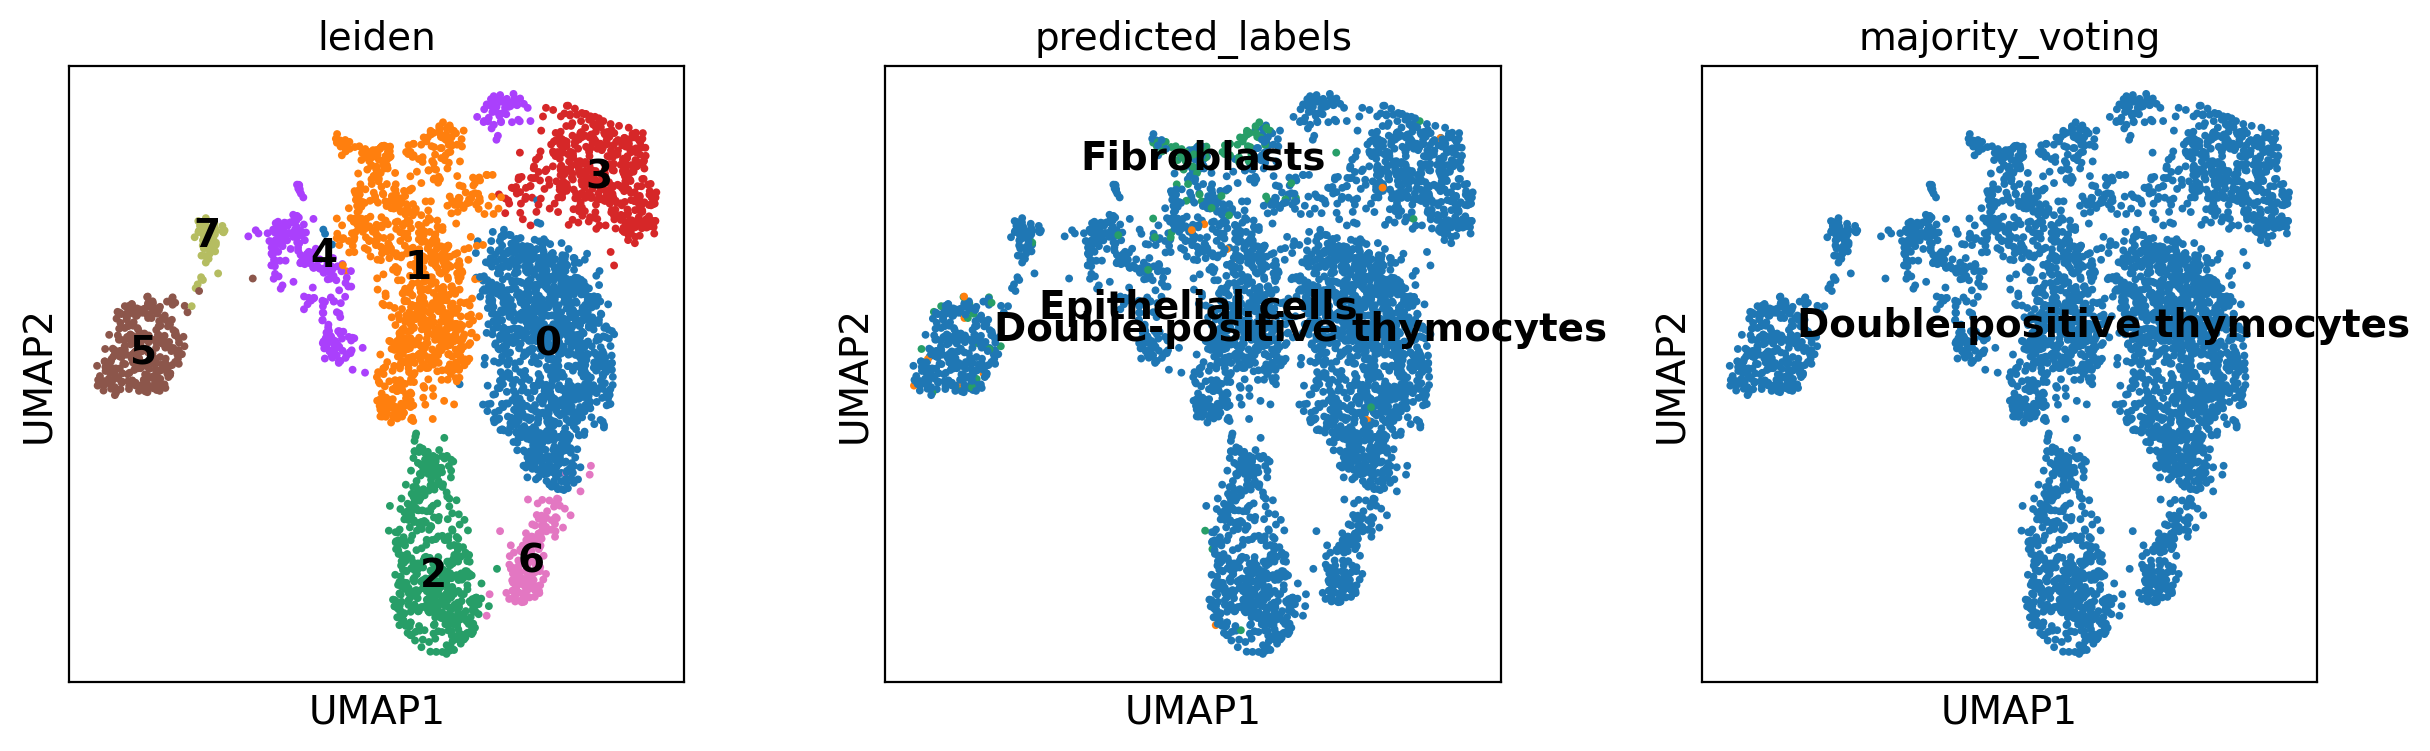

In [23]:
sc.pl.umap(adata, color =['leiden', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')